In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import torchtext
from torchtext.vocab import FastText

In [2]:
CA = pd.read_csv("data/CAvideos.csv")
CA['region'] = "CA"

In [3]:
DE = pd.read_csv("data/DEvideos.csv")
DE['region'] = "DE"

In [4]:
FR = pd.read_csv("data/FRvideos.csv")
FR['region'] = "FR"

In [5]:
GB = pd.read_csv("data/GBvideos.csv")
GB['region'] = "GB"

In [6]:
IN = pd.read_csv("data/INvideos.csv")
IN['region'] = "IN"

In [7]:
US = pd.read_csv("data/USvideos.csv")
US['region'] = "US"

In [8]:
full_data = pd.concat([CA, GB, IN, US], ignore_index = True)

In [9]:
full_data.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'region'],
      dtype='object')

In [10]:
full_data.isnull().sum().sort_values(ascending=False) #count missing values
number = full_data.isnull().sum().sort_values(ascending=False)
percent = (full_data.isnull().sum())/full_data.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([number, percent], axis=1,keys=['total', 'percent'],sort=False).sort_values('total',ascending=False)
missing_df.head()

,total,percent
description,3039,0.019222
likes,0,0.000000
video_error_or_removed,0,0.000000
ratings_disabled,0,0.000000
comments_disabled,0,0.000000


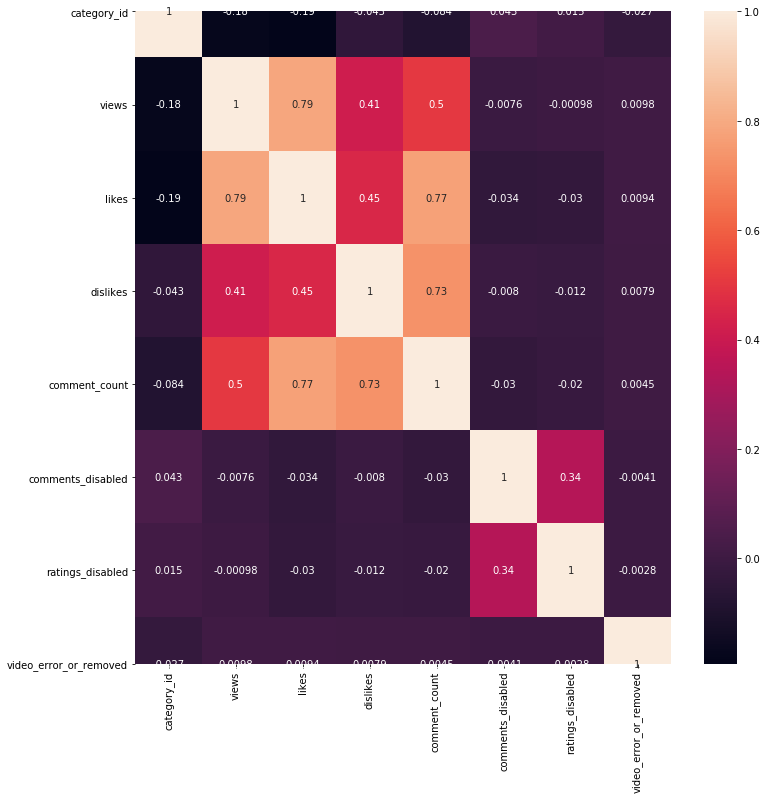

In [11]:
#the four features 
plt.figure(figsize=(12,12))
ax=sns.heatmap(full_data.corr(),annot=True)

In [12]:
#we chose number of views as the label, and we need to first deal with missing data in description
full_data['description'].fillna("#", inplace=True)

In [13]:
full_data.isnull().sum().sort_values(ascending=False) #count missing values
number = full_data.isnull().sum().sort_values(ascending=False)
percent = (full_data.isnull().sum())/full_data.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([number, percent], axis=1,keys=['total', 'percent'],sort=False).sort_values('total',ascending=False)
missing_df.head()

,total,percent
region,0,0.0
description,0,0.0
video_error_or_removed,0,0.0
ratings_disabled,0,0.0
comments_disabled,0,0.0


In [14]:
y = full_data["views"]
y.describe()

count    1.580980e+05
mean     2.613847e+06
std      1.059344e+07
min      5.490000e+02
25%      1.690242e+05
50%      4.956635e+05
75%      1.530977e+06
max      4.245389e+08
Name: views, dtype: float64

In [15]:
y_norm=(y-y.mean())/y.std()
y_norm.describe()


count    1.580980e+05
mean    -1.006727e-17
std      1.000000e+00
min     -2.466902e-01
25%     -2.307865e-01
50%     -1.999523e-01
75%     -1.022207e-01
max      3.982890e+01
Name: views, dtype: float64

In [16]:
def log_transform(x):
    x_float = float(x)
    return np.log(x_float)
y_new = y_norm.apply(log_transform)
y_new.describe()

count    26089.000000
mean        -1.260965
std          1.688200
min         -9.854084
25%         -2.330065
50%         -1.192227
75%         -0.086599
max          3.684593
Name: views, dtype: float64

In [17]:
#trending date
full_data['trending_date_new'] = pd.to_datetime(full_data.trending_date, format = "%y.%d.%m")

In [18]:
full_data.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'region', 'trending_date_new'],
      dtype='object')

In [19]:
X_raw = full_data.loc[:,['title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'description', 'region']]

In [20]:
import torchtext
from torchtext.vocab import FastText
FTmodel = FastText()

.vector_cache/wiki.en.vec: 6.60GB [06:12, 17.7MB/s]                               
100%|█████████▉| 2519275/2519370 [07:58<00:00, 5994.45it/s]

In [21]:
def parseCat(l):
    ll=str(l).lower().split()
    result = []
    for s in ll:
        result.append(s)
    return result
def parse_new(l):
    ll=str(l).lower().split('|')
    result = []
    for s in ll:
        result.append(s)
    return result

In [22]:
X_raw['title'] = X_raw['title'].apply(parseCat)
X_raw['channel_title'] = X_raw['channel_title'].apply(parseCat)
X_raw['tags'] = X_raw['tags'].apply(parse_new)
X_raw['description'] = X_raw['description'].apply(parseCat)
X_raw.head()

,title,channel_title,category_id,publish_time,tags,description,region
0,"[eminem, -, walk, on, water, (audio), ft., bey...",[eminemvevo],10,2017-11-10T17:00:03.000Z,"[eminem, ""walk"", ""on"", ""water"", ""aftermath/sha...","[eminem's, new, track, walk, on, water, ft., b...",CA
1,"[plush, -, bad, unboxing, fan, mail]",[idubbbztv],23,2017-11-13T17:00:00.000Z,"[plush, ""bad unboxing"", ""unboxing"", ""fan mail""...","[still, got, a, lot, of, packages., probably, ...",CA
2,"[racist, superman, |, rudy, mancuso,, king, ba...","[rudy, mancuso]",23,2017-11-12T19:05:24.000Z,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...","[watch, my, previous, video, ▶, \n\nsubscribe,...",CA
3,"[i, dare, you:, going, bald!?]",[nigahiga],24,2017-11-12T18:01:41.000Z,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...","[i, know, it's, been, a, while, since, we, did...",CA
4,"[ed, sheeran, -, perfect, (official, music, vi...","[ed, sheeran]",10,2017-11-09T11:04:14.000Z,"[edsheeran, ""ed sheeran"", ""acoustic"", ""live"", ...","[🎧:, https://ad.gt/yt-perfect\n💰:, https://atl...",CA


In [23]:
def embed(lst):
    
    emb_cat = []
    for j in range(0, len(lst)):
        cats = lst[j]
        n = len(cats)
        
        vec = FTmodel[str(cats[0]).lower()]
        if n > 1:
            for i in range(1, n):
                new_vec = FTmodel[str(cats[i]).lower()]
                vec = np.vstack((vec, new_vec))
            vec = vec.mean(axis = 0, keepdims = True)
        emb_cat.append(vec)
    return emb_cat


In [ ]:
title= embed(list(X_raw['title']))
channel_title = embed(list(X_raw['channel_title']))
tags = embed(list(X_raw['tags']))
description = embed(list(X_raw['description']))

In [ ]:
X = pd.concat([pd.DataFrame(title), pd.DataFrame(title), pd.DataFrame(title), pd.DataFrame(title), X_raw.category_id, X_raw.publish_time, X_raw.region])

In [ ]:
X_wtrain, X_wtest, y_wtrain, y_wtest = train_test_split(X, y_new, test_size = 0.05, random_state = 999)

In [ ]:
n_tree = [300, 600, 900]
max_depth = [50, 150, 300]
grid_param = {'n_estimators': n_tree, 'max_depth': max_depth}
model_w1 = RandomForestRegressor()
grid_model_w1 = GridSearchCV(estimator = model_w1, param_grid = grid_param, cv = 4, verbose = 2)
grid_model_w1.fit(X_wtrain, y_wtrain)

In [ ]:
grid_model_w1.best_params_
best_model_w1 = grid_model_w1.best_estimator_

In [ ]:
pred_w1 = best_model_w1.predict(X_wtest)
rms_w1 = mean_squared_error(y_wtest, pred_w1)
print(rms_w1)